# results.ipynb

## Qualitative Results and Predictions Demonstration
#

In [11]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

In [12]:
test_path = "../data/processed/test.jsonl"
assert os.path.exists(test_path), "Test file not found. Run preprocess and training steps first."

test_df = pd.read_json(test_path, lines=True)
print(f"Loaded test set with {len(test_df)} samples.")


Loaded test set with 20 samples.


## Load Phenotype/Gene Classes

In [13]:
train_path = "../data/processed/train.jsonl"
val_path = "../data/processed/val.jsonl"
train_df = pd.read_json(train_path, lines=True)
val_df = pd.read_json(val_path, lines=True)
combined_df = pd.concat([train_df, val_df], axis=0)

all_phenos = set()
all_genes = set()

for ph_list in combined_df['positive_phenotypes']:
    all_phenos.update(ph_list)
for gene_list in combined_df['all_candidate_genes']:
    all_genes.update(gene_list)

pheno_classes = sorted(list(all_phenos))
gene_classes = sorted(list(all_genes))

pheno_mlb = MultiLabelBinarizer(classes=pheno_classes)
gene_mlb = MultiLabelBinarizer(classes=gene_classes)

# Fit on combined and transform test
pheno_mlb.fit(combined_df['positive_phenotypes'])
gene_mlb.fit(combined_df['all_candidate_genes'])


MultiLabelBinarizer(classes=['ENSG00000012048', 'ENSG00000080815',
                             'ENSG00000121879', 'ENSG00000123374',
                             'ENSG00000133703', 'ENSG00000134982',
                             'ENSG00000136997', 'ENSG00000141510',
                             'ENSG00000142192', 'ENSG00000144285',
                             'ENSG00000146648', 'ENSG00000157764',
                             'ENSG00000177628', 'ENSG00000186868',
                             'ENSG00000188906'])

## Define Dataset Class

In [14]:
class PatientDataset(Dataset):
    def __init__(self, dataframe, pheno_mlb, gene_mlb):
        self.data = dataframe.copy()
        self.pheno_mlb = pheno_mlb
        self.gene_mlb = gene_mlb
        self.data['pheno_vec'] = list(self.pheno_mlb.transform(self.data['positive_phenotypes']))
        self.data['gene_vec'] = list(self.gene_mlb.transform(self.data['all_candidate_genes']))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        pheno_vec = torch.tensor(row['pheno_vec'], dtype=torch.float32)
        gene_vec = torch.tensor(row['gene_vec'], dtype=torch.float32)
        x = torch.cat([pheno_vec, gene_vec])
        y = torch.tensor([1.0 if row['true_diseases'] != 0 else 0.0], dtype=torch.float32)
        return x, y


## Load the MLP Model

In [19]:
train_path = "../data/processed/train.jsonl"
val_path = "../data/processed/val.jsonl"
test_path = "../data/processed/test.jsonl"

assert os.path.exists(train_path), "train.jsonl not found."
assert os.path.exists(val_path), "val.jsonl not found."
assert os.path.exists(test_path), "test.jsonl not found."

train_df = pd.read_json(train_path, lines=True)
val_df = pd.read_json(val_path, lines=True)
test_df = pd.read_json(test_path, lines=True)


# Collect classes as done in train_model.py
def collect_all_classes(paths):
    phenos = set()
    genes = set()
    for p in paths:
        df = pd.read_json(p, lines=True)
        for ph in df['positive_phenotypes']:
            phenos.update(ph)
        for gset in df['all_candidate_genes']:
            genes.update(gset)
    return sorted(list(phenos)), sorted(list(genes))


pheno_classes, gene_classes = collect_all_classes([train_path, val_path, test_path])
pheno_len = len(pheno_classes)
gene_len = len(gene_classes)

# Get clinical_len from a sample in the training set (as done in train_model.py)
sample_record = train_df.iloc[0]
clinical_len = len(sample_record['clinical_vec'])

input_dim = pheno_len + gene_len + clinical_len
print(f"pheno_len={pheno_len}, gene_len={gene_len}, clinical_len={clinical_len}, input_dim={input_dim}")

# Define the MLP model class exactly as in `train_model.py`.

import torch.nn as nn
import torch


class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sig(self.fc2(x))
        return x


model_path = "../data/model/neuro_model.pt"
assert os.path.exists(model_path), "Model weights not found. Run training first."

model = SimpleMLP(input_dim=input_dim, hidden_dim=128)
model.load_state_dict(torch.load(model_path))
model.eval()
print("Model loaded successfully without size mismatch.")


pheno_len=23, gene_len=15, clinical_len=14, input_dim=52
Model loaded successfully without size mismatch.


/var/folders/2d/np4wwh1x1njfn0hsd42hqll00000gn/T/ipykernel_68967/1770399551.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

##  Create a DataLoader for the Test Set

In [20]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer

# Initialize MLBs the same way as training
pheno_mlb = MultiLabelBinarizer(classes=pheno_classes)
gene_mlb = MultiLabelBinarizer(classes=gene_classes)
pheno_mlb.fit(train_df['positive_phenotypes'])  # Fit on train (consistency with training)
gene_mlb.fit(train_df['all_candidate_genes'])

class PatientDataset(Dataset):
    def __init__(self, dataframe, pheno_mlb, gene_mlb):
        self.data = dataframe.copy()
        # Transform phenotypes and genes
        self.data['pheno_vec'] = list(pheno_mlb.transform(self.data['positive_phenotypes']))
        self.data['gene_vec'] = list(gene_mlb.transform(self.data['all_candidate_genes']))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        pheno_vec = torch.tensor(row['pheno_vec'], dtype=torch.float32)
        gene_vec = torch.tensor(row['gene_vec'], dtype=torch.float32)
        clinical_vec = torch.tensor(row['clinical_vec'], dtype=torch.float32)  # Include clinical_vec
        x = torch.cat([pheno_vec, gene_vec, clinical_vec])
        y = torch.tensor([1.0 if row['true_diseases'] != 0 else 0.0], dtype=torch.float32)
        return x, y

test_data = PatientDataset(test_df, pheno_mlb, gene_mlb)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## Generate Predictions on the Test Set

In [21]:
all_preds = []
all_truth = []
with torch.no_grad():
    for Xb, yb in test_loader:
        preds = model(Xb)
        predicted = (preds >= 0.5).float().flatten().tolist()
        truth = yb.flatten().tolist()
        all_preds.extend(predicted)
        all_truth.extend(truth)

all_preds = np.array(all_preds)
all_truth = np.array(all_truth)

Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         6
         1.0       0.78      1.00      0.88        14

    accuracy                           0.80        20
   macro avg       0.89      0.67      0.69        20
weighted avg       0.84      0.80      0.76        20


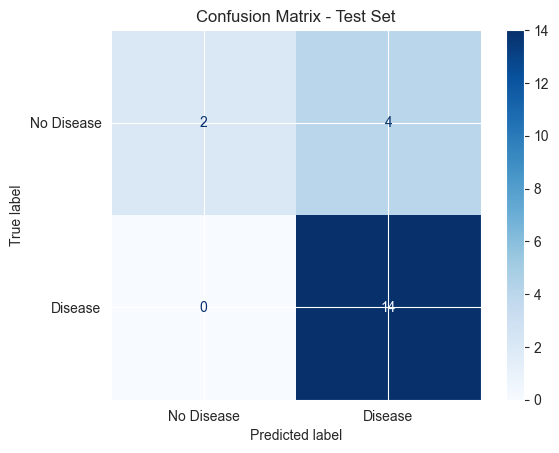

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

print("Classification Report (Test Set):")
print(classification_report(all_truth, all_preds, zero_division=0))

cm = confusion_matrix(all_truth, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Disease", "Disease"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()


## Inspect Individual Samples

In [23]:
import numpy as np
sample_indices = np.random.choice(len(test_df), 5, replace=False)

for i in sample_indices:
    record = test_df.iloc[i]
    x_ph = torch.tensor(pheno_mlb.transform([record['positive_phenotypes']])[0], dtype=torch.float32)
    x_g  = torch.tensor(gene_mlb.transform([record['all_candidate_genes']])[0], dtype=torch.float32)
    x_cl = torch.tensor(record['clinical_vec'], dtype=torch.float32)
    x = torch.cat([x_ph, x_g, x_cl]).unsqueeze(0)

    with torch.no_grad():
        pred = model(x)
    pred_label = 1 if pred.item() >= 0.5 else 0
    true_label = 1 if record['true_diseases'] != 0 else 0

    print("---------")
    print(f"Patient ID: {record['id']}")
    print(f"True Label: {'Disease' if true_label==1 else 'No Disease'}")
    print(f"Predicted:  {'Disease' if pred_label==1 else 'No Disease'}")
    print(f"Phenotypes: {record['positive_phenotypes']}")
    print(f"Genes: {record['all_candidate_genes']}")

---------
Patient ID: 463
True Label: Disease
Predicted:  Disease
Phenotypes: ['HP:0002076', 'HP:0002571', 'HP:0001337']
Genes: ['ENSG00000186868', 'ENSG00000142192']
---------
Patient ID: 492
True Label: Disease
Predicted:  Disease
Phenotypes: ['HP:0012378', 'HP:0009830']
Genes: ['ENSG00000144285', 'ENSG00000186868']
---------
Patient ID: 478
True Label: Disease
Predicted:  Disease
Phenotypes: ['HP:0000019', 'HP:0012378']
Genes: ['ENSG00000142192']
---------
Patient ID: 315
True Label: No Disease
Predicted:  Disease
Phenotypes: ['HP:0001251', 'HP:0010295']
Genes: ['ENSG00000144285', 'ENSG00000146648']
---------
Patient ID: 484
True Label: Disease
Predicted:  Disease
Phenotypes: ['HP:0100785', 'HP:0000713']
Genes: ['ENSG00000188906']
